In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from datatools import extract_market_data, data_quantization
from pipeline import Dataset
from pipeline.backtest import evaluation_for_submission, cross_validation
from pipeline.fundamental import calculate_fundamental_v0
from visualization.metric import plot_performance

import xarray as xr
from xarray import Dataset, DataArray


In [3]:
path = '../../data/nc'
base_ds = xr.open_dataset(f'{path}/base.nc')
market_brief_ds = xr.open_dataset(f'{path}/market_brief.nc')
ds = base_ds.merge(market_brief_ds)

fundamental_ds = calculate_fundamental_v0(ds)
fundamental_ds.to_netcdf(f'{path}/fundamental_v0.nc')

In [4]:
base_ds = xr.open_dataset('../../data/nc/base.nc')
market_brief_ds = xr.open_dataset('../../data/nc/market_brief.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc/fundamental_v0.nc')
ds = base_ds.merge(market_brief_ds).merge(fundamental_v0_ds)


In [4]:
ds_f = calculate_fundamental_v0(ds)
ds_f

<xarray.Dataset>
Dimensions:       (day: 998, asset: 54)
Coordinates:
  * day           (day) int32 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998
  * asset         (asset) int32 0 1 2 3 4 5 6 7 8 ... 45 46 47 48 49 50 51 52 53
Data variables:
    earnings_ttm  (day, asset) float64 0.708 0.5564 0.2103 ... 0.9956 0.9333
    earnings      (day, asset) float64 0.7549 0.5915 0.2154 ... 0.9956 0.9333
    book          (day, asset) float64 4.934 3.191 1.878 ... 2.629 4.989 4.981
    sales         (day, asset) float64 6.387 5.292 2.182 ... 5.299 7.77 24.41
    cashflow      (day, asset) float64 -0.04213 0.6771 ... -0.04956 0.07389
    market_share  (asset) float64 0.1026 0.07648 0.1451 ... 0.08603 0.09775
    market_cap    (asset, day) float64 2.503 2.422 2.436 ... 0.9527 0.9717

In [16]:
ds_f.keys()

KeysView(<xarray.Dataset>
Dimensions:       (day: 998, asset: 54)
Coordinates:
  * day           (day) int32 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998
  * asset         (asset) int32 0 1 2 3 4 5 6 7 8 ... 45 46 47 48 49 50 51 52 53
Data variables:
    earnings_ttm  (day, asset) float64 0.708 0.5564 0.2103 ... 0.9956 0.9333
    earnings      (day, asset) float64 0.7549 0.5915 0.2154 ... 0.9956 0.9333
    book          (day, asset) float64 4.934 3.191 1.878 ... 2.629 4.989 4.981
    sales         (day, asset) float64 6.387 5.292 2.182 ... 5.299 7.77 24.41
    cashflow      (day, asset) float64 -0.04213 0.6771 ... -0.04956 0.07389
    market_share  (asset) float64 0.1026 0.07648 0.1451 ... 0.08603 0.09775
    market_cap    (asset, day) float64 2.503 2.422 2.436 ... 0.9527 0.9717)

In [19]:
list(ds.keys())

['open',
 'close',
 'high',
 'low',
 'volume',
 'money',
 'turnoverRatio',
 'transactionAmount',
 'pe_ttm',
 'pe',
 'pb',
 'ps',
 'pcf',
 'return',
 'avg_price',
 'volatility',
 'mean_volume',
 'close_0',
 'open_0',
 'high_0',
 'low_0',
 'return_0']

In [5]:
ds_new = ds.merge(ds_f).dropna(dim='day')
ds_new

<xarray.Dataset>
Dimensions:            (day: 998, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/29)
    open               (day, asset, timeslot) float64 25.02 24.96 ... 9.941
    close              (day, asset, timeslot) float64 24.96 24.85 ... 9.941
    high               (day, asset, timeslot) float64 25.14 24.96 ... 9.941
    low                (day, asset, timeslot) float64 24.94 24.81 ... 9.88 9.941
    volume             (day, asset, timeslot) float64 6.422e+05 ... 1.851e+05
    money              (day, asset, timeslot) float64 1.61e+07 ... 1.839e+06
    ...                 ...
    earnings           (day, asset) float64 0.7549 0.5915 ... 0.9956 0.9333
    book               (day, asset) float64 4.934 3.191 1.878 ... 4.989 4.981
    sales              (day, asset) float64 6.387 5.292 2.182 ... 7.77 24.41
    cashflow           (day, asset) float64 -0.04213 0.6771 ... -0.04956 0.07389
    market_share       (asset) float64 0.1026 0.07648 0.1451 ... 0.08603 0.09775
    market_cap         (asset, day) float64 2.503 2.422 2.436 ... 0.9527 0.9717

In [24]:
list(ds_new.keys())

['open',
 'close',
 'high',
 'low',
 'volume',
 'money',
 'turnoverRatio',
 'transactionAmount',
 'pe_ttm',
 'pe',
 'pb',
 'ps',
 'pcf',
 'return',
 'avg_price',
 'volatility',
 'mean_volume',
 'close_0',
 'open_0',
 'high_0',
 'low_0',
 'return_0',
 'earnings_ttm',
 'earnings',
 'book',
 'sales',
 'cashflow',
 'market_share',
 'market_cap']

In [12]:
ds_new.isnull()

<xarray.Dataset>
Dimensions:            ()
Data variables: (12/29)
    open               bool False
    close              bool False
    high               bool False
    low                bool False
    volume             bool False
    money              bool False
    ...                 ...
    earnings           bool False
    book               bool False
    sales              bool False
    cashflow           bool False
    market_share       bool False
    market_cap         bool False

In [19]:
ds_new = ds_new.assign(day_feature=('day', ds_new['day'].data))
ds_new = ds_new.assign(asset_name=('asset', ds_new['asset'].data))

## Let's focus on correlation if we just want correlation!

In [5]:
from sklearn.preprocessing import RobustScaler
import torch
from torch import optim, nn
from model.neural_network import NN_wrapper
from torchmetrics import PearsonCorrCoef

In [6]:
def winsorize(X, q=0.1):
    lower = X.quantile(q)
    upper = X.quantile(1-q)
    return X.clip(lower, upper, axis=1)

class CombinedScaler:
    def __init__(self):
        self.scaler = RobustScaler()

    def fit_transform(self, X):
        X = winsorize(DataFrame(X))
        return self.scaler.fit_transform(X)

    def transform(self, X):
        X = winsorize(DataFrame(X))
        return self.scaler.transform(X)

class Neg_Pearson_Loss(nn.Module):
    def __init__(self) -> None:
        super(Neg_Pearson_Loss, self).__init__( )

    def forward(self, pred, target):
        # loss_without_reduction = max(0, −target * (input1 − input2) + margin)
        pearson = PearsonCorrCoef()
        return -pearson(pred.squeeze(), target.squeeze())


## CV

In [13]:
IS_CUDA = torch.cuda.is_available()
IS_CUDA


False

In [32]:
feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap']
train_lookback = 16
eval_lookback = 4
preprocess = CombinedScaler()
lr = 5e-4
n_epoch = 10
constructor = lambda o: optim.lr_scheduler.CyclicLR(o, base_lr=lr / 10, max_lr=lr, step_size_up=n_epoch // 2,
                                                    cycle_momentum=False)

torch.manual_seed(2023)
np.random.seed(2023)

model = NN_wrapper(preprocess=preprocess, lr=lr, lr_scheduler_constructor=constructor, n_epoch=n_epoch,
                   train_lookback=train_lookback, per_eval_lookback=eval_lookback, hidden_size=128, n_asset=54,
                   network='Transformer', feature_name=feature, load_model_path=None, criterion='pearson',
                   embed_asset=True, embed_offset=True, is_eval=False, var_weight=0,
                   is_cuda=IS_CUDA)
ds_cv = ds.sel(day=slice(200, ds.dims['day'] - 2))[feature + ['return']]
performance_cv, cum_y_df = cross_validation(model, feature, ds=ds_cv, train_lookback=train_lookback,
                                            per_eval_lookback=eval_lookback)

embedding feature dimension is 68


  0%|          | 0/779 [00:00<?, ?it/s]

training loss: -0.10532840341329575
training loss: -0.27251163125038147
training loss: -0.32600903511047363
training loss: -0.28413939476013184
training loss: -0.2770209312438965
training loss: -0.29672324657440186
training loss: -0.288887619972229
training loss: -0.261478453874588
training loss: -0.2828379273414612
training loss: -0.3163501024246216
training loss: -0.3448735475540161
training loss: -0.3777913749217987
training loss: -0.44092899560928345
training loss: -0.2963589131832123
training loss: -0.2704775929450989
training loss: -0.31092575192451477
training loss: -0.36094993352890015
training loss: -0.4202252924442291
training loss: -0.4123556911945343
training loss: -0.39993369579315186
training loss: -0.35587742924690247
training loss: -0.4061696231365204
training loss: -0.41609105467796326
training loss: -0.4063429534435272
training loss: -0.4134812653064728
training loss: -0.39458951354026794
training loss: -0.3633815348148346
training loss: -0.39858976006507874
training 

KeyboardInterrupt: 

The ending score for metric val_cum_r2 is: -2.3850e+04
The ending score for metric val_cum_pearson is: 8.1825e-02


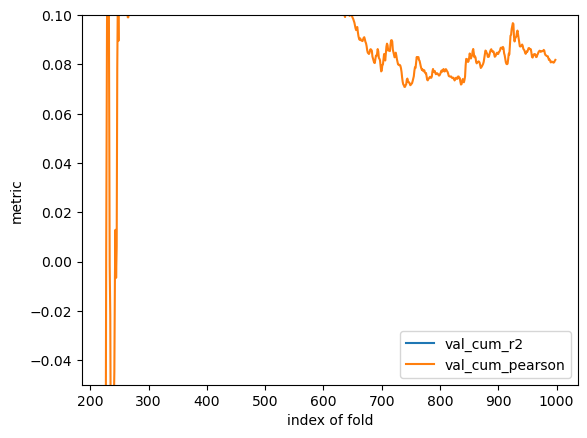

In [35]:
plt.figure(0)
plot_performance(performance_cv, metrics_selected=['val_cum_pearson', 'val_cum_r2'])
plt.show()

## LSTM
Training pearson can achieve an average around 0.3 but cum_pearson is never positive :(
- That was because I didn't remove the clip during prediction!!

**L1+L2 regularization**: training pearson: 0.05\~0.1; cum_pearson around 0.005\~0.01
**L2 regularization**: training pearson:\~0.3; cum_pearson around 0.01\~0.02
**No regularization**: training pearson: \~0.2; cum_pearson around 0 :(



## Transformer
Training pearson can achieve an average around 0.5~0.6! but cum_pearson is never positive :(
- That was because I didn't remove the clip during prediction!!

**L2 regularization**: training pearson:\~0.6; cum_pearson -> 0.06
        double-checked: training\~0.6; val cum -> 0.02
**No regularization**: training pearson: 0.5\~0.6; cum_pearson -> -0.01??
        double-checked: training\~0.6; val cum -> 0\~0.01

In [52]:
cum_y_df

In [9]:
from qids_lib import QIDS

qids = QIDS(path_prefix='../../')


In [11]:
load_model_path = '../../model/dump/2023-03-05/2023-03-05_Transformer-F2048_S0867'
feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap']
train_lookback = 16
eval_lookback = 4
preprocess = CombinedScaler()
lr = 5e-4
n_epoch = 1
# constructor = lambda o: optim.lr_scheduler.CyclicLR(o, base_lr=lr/100, max_lr=lr, step_size_up=n_epoch // 2,
#                                                     cycle_momentum=False)
torch.manual_seed(2023)
np.random.seed(2023)

model = NN_wrapper(preprocess=preprocess, lr=lr, lr_scheduler_constructor=None, n_epoch=n_epoch,
                   train_lookback=train_lookback, per_eval_lookback=eval_lookback, hidden_size=2048, n_asset=54,
                   network='Transformer', feature_name=feature, load_model_path=load_model_path,
                   embed_asset=True, embed_offset=True, criterion=Neg_Pearson_Loss(),
                   is_eval=True,
                   is_cuda=IS_CUDA)
performance_eval, y_pred = evaluation_for_submission(model, given_ds=ds, lookback_window=train_lookback,
                                             per_eval_lookback=eval_lookback, qids=qids)

embedding feature dimension is 68


  0%|          | 0/700 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [88]:
y_pred

day   asset
1     0              NaN
      1              NaN
      2              NaN
      3              NaN
      4              NaN
                 ...    
1700  49      -14.349005
      50      -14.954153
      51      -15.940737
      52      -15.614066
      53      -14.677574
Name: return_pred, Length: 91800, dtype: float64

In [27]:
y_pred.iloc[1000*54:]

day   asset
1001  0        -1.862880
      1        -0.785796
      2        -1.527502
      3        -2.912339
      4        -2.461048
                 ...    
1700  49       -9.798071
      50       -9.860412
      51      -11.103057
      52      -10.765230
      53       -9.985248
Name: return_pred, Length: 37800, dtype: float64

In [96]:
y_submit = y_pred.iloc[1000*54:].reset_index()

In [97]:
y_submit

,day,asset,return_pred
0,1001,0,-18.305485
1,1001,1,-12.616443
2,1001,2,-10.937305
3,1001,3,-12.207618
4,1001,4,-16.794228
...,...,...,...
37795,1700,49,-14.349005
37796,1700,50,-14.954153
37797,1700,51,-15.940737
37798,1700,52,-15.614066


In [102]:
filename = 'dump/results/Transformer_Mar05_0507_submission.csv'


In [101]:
y_submit

,date_time,return
0,s0d1001,-18.305485
1,s1d1001,-12.616443
2,s2d1001,-10.937305
3,s3d1001,-12.207618
4,s4d1001,-16.794228
...,...,...
37795,s49d1700,-14.349005
37796,s50d1700,-14.954153
37797,s51d1700,-15.940737
37798,s52d1700,-15.614066


In [103]:
y_submit.to_csv(filename,index=False)

In [12]:
from datatools import generate_sbumission

# template:
# generate_sbumission(y_submit, filename)